In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import math
from glob import glob
from matplotlib.backends.backend_pdf import PdfPages
from scipy.fft import fft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy import signal
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model

import tensorflow as tf


%matplotlib inline

Using TensorFlow backend.
C:\Users\alexl\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alexl\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alexl\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alexl\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
list_=[]
filenames=glob("C:/frog/ALL1/*.txt")
#filenames=glob("C:/frog/try/新增資料夾/*.txt")
for file in filenames:
    df=pd.read_csv(file,low_memory=False)
    list_.append(df)

In [3]:
list_test=[]
filenames=glob("C:/frog/ALL1/1/*.txt")
#filenames=glob("C:/frog/try/新增資料夾/新增資料夾/*.txt")

for file in filenames:
    df=pd.read_csv(file,low_memory=False)
    list_test.append(df)

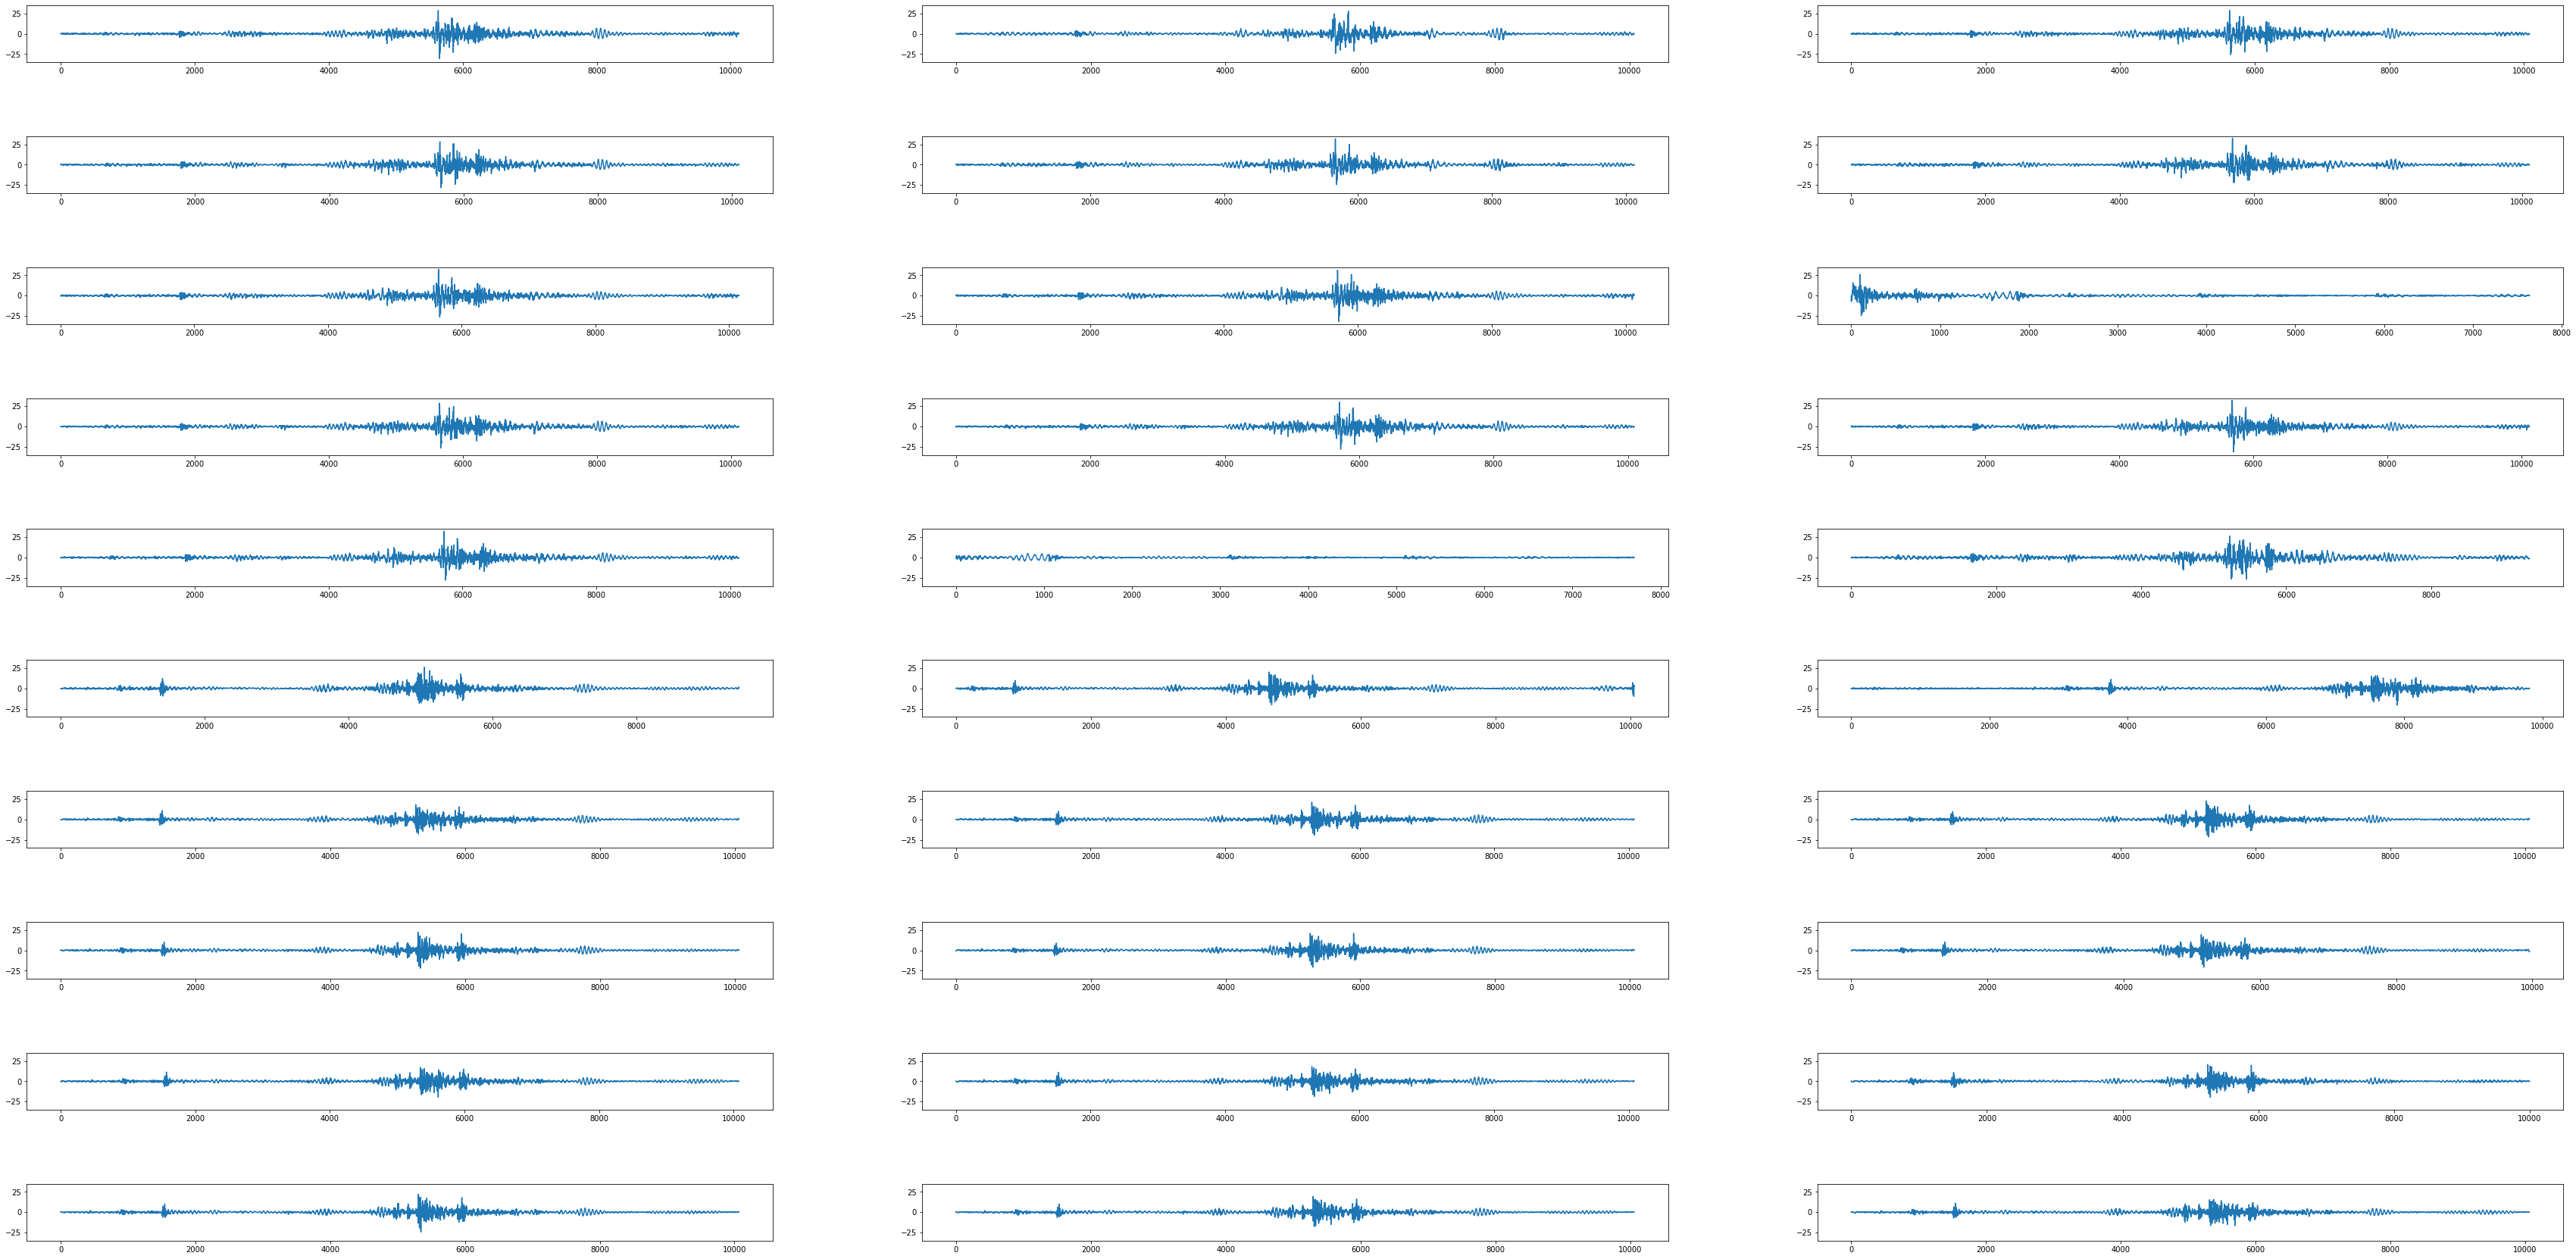

In [4]:
cc=1
for i in range(0,30):
    plt.gcf().set_size_inches(60, 30)
    plt.subplot(10,3,cc)
    #x=list_[i]['chainage']
    y=list_[i]['AI2']
    #y1=list_[i]['AI5']
    #speed=list_[i]['S']
    aa=str(list_[i]['time'].values[1])
    bb=aa[0:16]
    plt.plot(y,label="AI2")
    #plt.plot(x,y1,'r',label="AI5",alpha=0.5)
    #plt.plot(x,speed,'b',alpha=0.5)
    plt.subplots_adjust(hspace = 1.3)

    #plt.xlim(43450,43490)
    #plt.xlim(7300,6435)
    plt.ylim((-35,35))
    cc=cc+1

In [5]:
#for train and testing
hilbert_list=[]
for i in range(0,len(list_)):
    x1=list_[i]['AI2']
    peaks, _= find_peaks(x1,height=0, distance=1)
    hilbert_list.append(x1[peaks])

hilbert_list_test=[]
for i in range(0,len(list_test)):
    x2=list_test[i]['AI2']
    peaks, _= find_peaks(x2,height=0, distance=1)
    hilbert_list_test.append(x2[peaks])
    
for i in range(0,len(hilbert_list)):
    hilbert_list[i]=hilbert_list[i][0:800]
    
    
for i in range(0,len(hilbert_list_test)):
    hilbert_list_test[i]=hilbert_list_test[i][0:800]
    
list_max=[]
for i in range(0,len(hilbert_list)):
    list_max.append(hilbert_list[i].max())
    
list_max_test=[]
for i in range(0,len(hilbert_list_test)):
    list_max_test.append(hilbert_list_test[i].max())
    
list_1or0=[]
for i in range(0,len(hilbert_list)):
    if list_max[i]>=15:
        list_1or0.append(1)
    else:
        list_1or0.append(0)

list_Y=np.array(list_1or0).reshape(449  ,)

list_1or0_test=[]
for i in range(0,len(hilbert_list_test)):
    if list_max_test[i]>=15:
        list_1or0_test.append(1)
    else:
        list_1or0_test.append(0)

list_Y_test=np.array(list_1or0_test).reshape(106 ,)

arrayx=np.array(hilbert_list).reshape(449 ,800)
pdX=pd.DataFrame(arrayx)


arrayx1=np.array(hilbert_list_test).reshape(106,800)
pdX_test=pd.DataFrame(arrayx1)

In [6]:
#for new station added into the model accuracy

from sklearn.model_selection import train_test_split

#X=list_X
X=pdX
Y=list_Y

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)
X_train=X
X_test=pdX_test
Y_train=list_Y                   #label
Y_test=list_Y_test          #label

from sklearn import svm, metrics

classifier=svm.SVC(kernel='linear',gamma='auto',C=6,random_state=1)
classifier.fit(X_train,Y_train)

y_predict=classifier.predict(X_test)





from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_predict)

0.9716981132075472

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
ConfusionMatrix= confusion_matrix(Y_test,y_predict)
ConfusionMatrix

array([[49,  2],
       [ 1, 54]], dtype=int64)

In [6]:
#AE

X_train_np=np.array(hilbert_list)
X_test_np=np.array(hilbert_list_test)

X_train_np=np.array(X_train_np)
X_test_np=np.array(X_test_np)

X_min = np.min(X_train_np, axis=0)
X_max = np.max(X_train_np, axis=0)
X_train_np -= X_min
X_test_np -= X_min
X_train_np /= (X_max-X_min)
X_test_np /= (X_max-X_min)


from tensorflow import keras


input_data = Input(shape=(800,))

encoded = Dense(128, activation='relu', name='Encoder_1')(input_data)
#encoded = Dense(128, activation='relu', name='Ecnoder_3')(encoded)
encoded = Dense(64, activation='relu', name='Encoder_4')(encoded)
encoded = Dense(32, activation='relu', name='Encoder_5')(encoded)
encoder_output = Dense(16, name='Bottleneck')(encoded)


decoded = Dense(32, activation='relu', name='Decoder_1')(encoder_output)
decoded = Dense(64, activation='relu', name='Decoder_2')(decoded)
decoded = Dense(128, activation='relu', name='Decoder_3')(decoded)
#decoded = Dense(256, activation='relu', name='Decoder_4')(decoded)
output_data = Dense(800, activation='sigmoid', name='Output')(decoded)


metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

In [7]:


AE=Model(input_data, output_data)
encoder = Model(inputs=input_data, outputs=encoder_output)    
AE.compile(optimizer='adam', loss='MSE', metrics= metrics)
AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 800)               0         
_________________________________________________________________
Encoder_1 (Dense)            (None, 128)               102528    
_________________________________________________________________
Encoder_4 (Dense)            (None, 64)                8256      
_________________________________________________________________
Encoder_5 (Dense)            (None, 32)                2080      
_________________________________________________________________
Bottleneck (Dense)           (None, 16)                528       
_________________________________________________________________
Decoder_1 (Dense)            (None, 32)                544       
_________________________________________________________________
Decoder_2 (Dense)            (None, 64)                2112

In [8]:
#class_weight={0:weight_for_0, 1:weight_for_1}

#history=AE.fit(X_train_np, X_train_np,epochs=100,batch_size=128,validation_data=(X_test_np,X_test_np),verbose = 1)
history=AE.fit(X_train_np, X_train_np,epochs=100,batch_size=128,verbose = 1) #shuffle=True ,verbose = 1)#shuffle=True ,verbose = 1)


Epoch 1/100
449/449 [==============================] - 1s 1ms/step - loss: 0.1654 - fn: 137348.0000 - fp: 238.5000 - tn: 310.7500 - tp: 105502.7500 - precision: 0.9977 - recall: 0.4483
Epoch 2/100
449/449 [==============================] - 0s 84us/step - loss: 0.1494 - fn: 397397.5000 - fp: 456.2500 - tn: 878.7500 - tp: 203867.5000 - precision: 0.9978 - recall: 0.3430
Epoch 3/100
449/449 [==============================] - 0s 96us/step - loss: 0.0993 - fn: 707569.2500 - fp: 570.0000 - tn: 1576.2500 - tp: 252084.5000 - precision: 0.9977 - recall: 0.2646
Epoch 4/100
449/449 [==============================] - 0s 100us/step - loss: 0.0466 - fn: 1049754.5000 - fp: 608.7500 - tn: 2340.2500 - tp: 268296.5000 - precision: 0.9977 - recall: 0.2046
Epoch 5/100
449/449 [==============================] - 0s 96us/step - loss: 0.0324 - fn: 1405213.0000 - fp: 615.5000 - tn: 3135.2500 - tp: 271236.2500 - precision: 0.9977 - recall: 0.1624
Epoch 6/100
449/449 [==============================] - 0s 96us/s

449/449 [==============================] - 0s 84us/step - loss: 0.0188 - fn: 15024317.0000 - fp: 616.0000 - tn: 33538.7500 - tp: 271329.0000 - precision: 0.9977 - recall: 0.0177
Epoch 44/100
449/449 [==============================] - 0s 122us/step - loss: 0.0184 - fn: 15382730.0000 - fp: 616.0000 - tn: 34325.5000 - tp: 271329.0000 - precision: 0.9977 - recall: 0.0173
Epoch 45/100
449/449 [==============================] - 0s 107us/step - loss: 0.0181 - fn: 15741120.0000 - fp: 616.0000 - tn: 35135.5000 - tp: 271329.0000 - precision: 0.9977 - recall: 0.0169
Epoch 46/100
449/449 [==============================] - 0s 113us/step - loss: 0.0178 - fn: 16099514.0000 - fp: 616.0000 - tn: 35941.7500 - tp: 271329.0000 - precision: 0.9977 - recall: 0.0166
Epoch 47/100
449/449 [==============================] - 0s 107us/step - loss: 0.0175 - fn: 16457944.0000 - fp: 616.0000 - tn: 36711.7500 - tp: 271329.0000 - precision: 0.9977 - recall: 0.0162
Epoch 48/100
449/449 [==============================] 

In [9]:
test_x_predictions=AE.predict(X_test)
mse=np.mean(np.power(X_test-test_x_predictions,2), axis=1)


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

threshold_fixed=15

perd_y =[1 if e>threshold_fixed else 0 for e in mse.values]

ConfusionMatrix= confusion_matrix(Y_test, perd_y)
fraction=(ConfusionMatrix[0][0]+ConfusionMatrix[1][1])
denominator=np.sum(ConfusionMatrix[0][0]+ConfusionMatrix[0][1])+np.sum(ConfusionMatrix[1][0]+ConfusionMatrix[1][1])
accuracy=fraction/denominator
accuracy

0.9150943396226415

In [10]:
ConfusionMatrix

array([[51,  0],
       [ 9, 46]], dtype=int64)

In [85]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score


In [86]:
threshold_fixed=15

perd_y =[1 if e>threshold_fixed else 0 for e in mse.values]

In [87]:
ConfusionMatrix= confusion_matrix(Y_test, perd_y)
ConfusionMatrix

array([[51,  0],
       [ 9, 46]], dtype=int64)

In [88]:
fraction=(ConfusionMatrix[0][0]+ConfusionMatrix[1][1])

In [89]:
denominator=np.sum(ConfusionMatrix[0][0]+ConfusionMatrix[0][1])+np.sum(ConfusionMatrix[1][0]+ConfusionMatrix[1][1])

In [90]:
accuracy=fraction/denominator
accuracy

0.9150943396226415

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="testing Loss")
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,0.5])
plt.legend()